# DistilBERT model
This notebook trains the DistilBERT model and exports a set of predictions for a test dataset.

**Trains on:** Waseem and Hovy (2016)

First we need to install the required packages.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 6.6 MB/s 
     |████████████████████████████████| 120 kB 63.4 MB/s 
     |████████████████████████████████| 6.6 MB 46.8 MB/s 


In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 7.4 MB/s 
     |████████████████████████████████| 212 kB 66.5 MB/s 
     |████████████████████████████████| 115 kB 52.3 MB/s 
     |████████████████████████████████| 127 kB 61.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install "ray[tune]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59.4 MB 1.3 MB/s 
     |████████████████████████████████| 8.8 MB 36.1 MB/s 
     |████████████████████████████████| 4.1 MB 37.9 MB/s 
     |████████████████████████████████| 125 kB 51.4 MB/s 
     |████████████████████████████████| 468 kB 35.0 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.47.0
    Uninstalling grpcio-1.47.0:
      Successfully uninstalled grpcio-1.47.0


In [ ]:
!pip install wordsegment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 6.3 MB/s 


In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizer
import numpy as np
from datasets import load_metric, load_dataset, Dataset
from sklearn.model_selection import train_test_split
import pickle
import torch
from google.colab import drive
import preprocessor as p
import html
from torch.utils.data import DataLoader
import torch.nn.functional as nn
from ray.tune.schedulers import PopulationBasedTraining

# Mount drive for loading the datasets
drive.mount('/content/drive')
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/')

from reader import Reader

FILENAME = "drive/MyDrive/Colab Notebooks/data/twitter_data.pkl"
NUM_LABELS = 2

Mounted at /content/drive


## Split and tokenize the datasets

In [ ]:
class HateDataset(torch.utils.data.Dataset):
    """Dataset class used for combining the data encodings and labels."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
X, y = Reader.load(FILENAME)
X = Reader.preprocess(X)

mapping = {'racism': 1,'sexism': 1, 'none': 0}
y = [mapping[b] for b in y]

X_train, X_val, X_test, y_train, y_val, y_test = Reader.split_with_validation(X, y)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize all datasets
train_encodings =   
val_encodings = tokenizer(X_val, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

# Combine the encodings with the labels to Torch datasets
train_dataset = HateDataset(train_encodings, y_train)
val_dataset = HateDataset(val_encodings, y_val)
test_dataset = HateDataset(test_encodings, y_test)

## Load accuracy metric for the model's evaluation

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## Setup DistilBERT model

In [ ]:
def model_init():
    return DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=NUM_LABELS)
    
training_args = TrainingArguments(output_dir="train", evaluation_strategy="epoch")

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset ,
    compute_metrics=compute_metrics
)

scheduler = PopulationBasedTraining(
        metric='objective',
        mode='max',
        perturbation_interval=600.0,
        hyperparam_mutations={
            "per_device_train_batch_size": [16, 32],
            "learning_rate": [2e-5, 3e-5, 5e-5],
            "num_train_epochs": [2, 3, 4]
        })

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpg0ptt02y


storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight

## Training

In [ ]:
best_trial = trainer.hyperparameter_search(
    direction="maximize", 
    backend="ray", 
    n_trials=10,
    scheduler=scheduler
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(best_trial)

BestRun(run_id='4e5f2_00005', objective=0.8586078309509012, hyperparameters={'learning_rate': 1.1207606211860595e-05, 'num_train_epochs': 4, 'seed': 1.8994345766152145, 'per_device_train_batch_size': 16})


In [ ]:
learning_rate = best_trial.hyperparameters['learning_rate']
num_train_epochs = best_trial.hyperparameters['num_train_epochs']
per_device_train_batch_size = best_trial.hyperparameters['per_device_train_batch_size']
seed = best_trial.hyperparameters['seed']

In [ ]:
setattr(trainer.args, 'learning_rate', learning_rate)
setattr(trainer.args, 'num_train_epochs', num_train_epochs)
setattr(trainer.args, 'per_device_train_batch_size', per_device_train_batch_size)
setattr(trainer.args, 'seed', 42)

trainer.train()

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

Epoch,Training Loss,Validation Loss,Accuracy
1,0.387900,0.387145,0.848353
2,0.319700,0.400404,0.857365
3,0.264800,0.477614,0.852393
4,0.194300,0.534339,0.854568


Saving model checkpoint to train/checkpoint-500
Configuration saved in train/checkpoint-500/config.json
Model weights saved in train/checkpoint-500/pytorch_model.bin
Saving model checkpoint to train/checkpoint-1000
Configuration saved in train/checkpoint-1000/config.json
Model weights saved in train/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3218
  Batch size = 8
Saving model checkpoint to train/checkpoint-1500
Configuration saved in train/checkpoint-1500/config.json
Model weights saved in train/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to train/checkpoint-2000
Configuration saved in train/checkpoint-2000/config.json
Model weights saved in train/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3218
  Batch size = 8
Saving model checkpoint to train/checkpoint-2500
Configuration saved in train/checkpoint-2500/config.json
Model weights saved in train/checkpoint-2500/pytorch_model.bin
Saving model check

TrainOutput(global_step=4828, training_loss=0.2968224997153041, metrics={'train_runtime': 324.3431, 'train_samples_per_second': 119.059, 'train_steps_per_second': 14.885, 'total_flos': 779293287474624.0, 'train_loss': 0.2968224997153041, 'epoch': 4.0})

In [ ]:
path = F"drive/MyDrive/Colab Notebooks/output/distilbert-waseem-hovy.pth" 
trainer.save_model(path)

Saving model checkpoint to drive/MyDrive/Colab Notebooks/output/distilbert-waseem-hovy.pth
Configuration saved in drive/MyDrive/Colab Notebooks/output/distilbert-waseem-hovy.pth/config.json
Model weights saved in drive/MyDrive/Colab Notebooks/output/distilbert-waseem-hovy.pth/pytorch_model.bin


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(path)

loading configuration file drive/MyDrive/Colab Notebooks/output/distilbert-waseem-hovy.pth/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file drive/MyDrive/Colab Notebooks/output/distilbert-waseem-hovy.pth/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassificatio

## Model calibration
We use temperature scaling to calibrate the model on the validation set by finding the optimal T value.

In [ ]:
import sys
sys.path.append("drive/MyDrive/Colab Notebooks")
from temperature_scaling import ModelWithTemperature


In [ ]:
calibrated_model = ModelWithTemperature(model)
val_loader = DataLoader(val_dataset)

# Find optimal T value to calibrate the model
calibrated_model.set_temperature(val_loader)


Before temperature - NLL: 0.448, ECE: 0.073
Optimal temperature: 1.468
After temperature - NLL: 0.476, ECE: 0.123


ModelWithTemperature(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (

## Export model

In [ ]:
path = F"drive/MyDrive/Colab Notebooks/output/distilbert-waseem-hovy-calibrated.pth" 
torch.save(calibrated_model, path)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

logits = []
labels = []

test_loader = DataLoader(test_dataset)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)
        outputs = calibrated_model(input_ids, attention_mask=attention_mask)
        logits.append(outputs.tolist()[0])
        labels.append(label)

probabilities = nn.softmax(torch.tensor(logits), dim=1)
print(probabilities.tolist()[:10])

[[0.9796496629714966, 0.020350322127342224], [0.980379581451416, 0.019620444625616074], [0.04925457015633583, 0.9507454633712769], [0.9820011258125305, 0.01799888163805008], [0.3021566867828369, 0.6978432536125183], [0.9754274487495422, 0.024572527036070824], [0.9850937128067017, 0.014906293712556362], [0.982828676700592, 0.017171364277601242], [0.9824798107147217, 0.017520174384117126], [0.3927055597305298, 0.6072944402694702]]


In [ ]:
predictions = torch.argmax(probabilities, dim=-1)
metric = load_metric("accuracy")
accuracy = metric.compute(predictions=predictions, references=labels)
print("Test dataset: ", accuracy)

Test dataset:  {'accuracy': 0.8495960223741454}


[[0.9796496629714966, 0.020350322127342224], [0.980379581451416, 0.019620444625616074], [0.04925457015633583, 0.9507454633712769], [0.9820011258125305, 0.01799888163805008], [0.3021566867828369, 0.6978432536125183], [0.9754274487495422, 0.024572527036070824], [0.9850937128067017, 0.014906293712556362], [0.982828676700592, 0.017171364277601242], [0.9824798107147217, 0.017520174384117126], [0.3927055597305298, 0.6072944402694702], [0.04700440540909767, 0.9529955387115479], [0.9872883558273315, 0.012711632065474987], [0.9788252711296082, 0.021174738183617592], [0.987434446811676, 0.012565594166517258], [0.020037304610013962, 0.9799627065658569], [0.9652445316314697, 0.034755460917949677], [0.1480097621679306, 0.8519902229309082], [0.03994656726717949, 0.9600534439086914], [0.9694247841835022, 0.030575281009078026], [0.9294814467430115, 0.0705186128616333], [0.9858313798904419, 0.01416862290352583], [0.9804808497428894, 0.019519086927175522], [0.988379955291748, 0.011620056815445423], [0.9

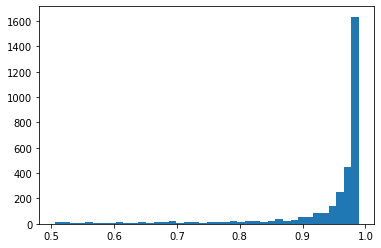

In [ ]:
import matplotlib.pyplot as plt
print(probabilities.tolist())
probs = np.max(probabilities.tolist(), axis=1)
print(probs)
plt.hist(probs, bins=40)
plt.show()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

logits = []
labels = []

test_loader = DataLoader(test_dataset)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits.append(outputs.logits.tolist()[0])
        labels.append(label)

probabilities = nn.softmax(torch.tensor(logits), dim=1)
print(probabilities.tolist()[:10])

[[0.9966238737106323, 0.003376137465238571], [0.9968030452728271, 0.0031969461124390364], [0.012792848981916904, 0.9872071146965027], [0.9971891045570374, 0.0028109229169785976], [0.22637610137462616, 0.7736238837242126], [0.9955239295959473, 0.004476124886423349], [0.9978771209716797, 0.00212295213714242], [0.9973795413970947, 0.002620507264509797], [0.99729984998703, 0.0027002221904695034], [0.3452392518520355, 0.6547607183456421]]


In [ ]:
predictions = torch.argmax(probabilities, dim=-1)
metric = load_metric("accuracy")
accuracy = metric.compute(predictions=predictions, references=labels)
print("Test dataset: ", accuracy)

Test dataset:  {'accuracy': 0.8495960223741454}


[[0.9966238737106323, 0.003376137465238571], [0.9968030452728271, 0.0031969461124390364], [0.012792848981916904, 0.9872071146965027], [0.9971891045570374, 0.0028109229169785976], [0.22637610137462616, 0.7736238837242126], [0.9955239295959473, 0.004476124886423349], [0.9978771209716797, 0.00212295213714242], [0.9973795413970947, 0.002620507264509797], [0.99729984998703, 0.0027002221904695034], [0.3452392518520355, 0.6547607183456421], [0.011913304217159748, 0.9880867004394531], [0.998324453830719, 0.0016755922697484493], [0.9964175224304199, 0.0035825097002089024], [0.9983528852462769, 0.0016470975242555141], [0.0032988800667226315, 0.9967010617256165], [0.9924610257148743, 0.007539013400673866], [0.07111771404743195, 0.9288823008537292], [0.009305426850914955, 0.990694522857666], [0.9937851428985596, 0.006214892491698265], [0.9778152108192444, 0.022184770554304123], [0.9980313181877136, 0.0019686550367623568], [0.9968276619911194, 0.00317232683300972], [0.9985333681106567, 0.0014665895

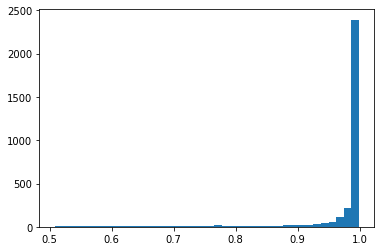

In [ ]:
import matplotlib.pyplot as plt
print(probabilities.tolist())
probs = np.max(probabilities.tolist(), axis=1)
print(probs)
plt.hist(probs, bins=40)
plt.show()